In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import pandas as pd

In [2]:
! pwd
expr_df = pd.read_csv("../metadata/length_and_depth.csv")
expr_df = expr_df.drop("nvar", axis=1)
expr_df = expr_df.rename(columns={
    "length" : "expr_length",
    "depth" : "expr_depth"
})
expr_df

/Users/felixgao/Desktop/Year3/STA378/OptimizationParameterTuning/Julia Notebook/src


,problem,objtype,variable_nvar,expr_length,expr_depth
0,NZF1,least_squares,True,250,8
1,arglina,least_squares,True,10404,9
2,arglinb,least_squares,True,40200,8
3,arglinc,other,True,39204,7
4,argtrig,other,True,497,7
...,...,...,...,...,...
100,tridia,other,True,398,6
101,vardim,other,True,798,6
102,vibrbeam,least_squares,False,481,13
103,watson,least_squares,False,3900,12


In [3]:
complete_df = pd.read_csv("../results/complete_dataset_as_of_nov6.csv")
complete_df = complete_df[complete_df["is_init_run"] == 0]
complete_df = complete_df.rename(columns={"name" : "problem"})
df = complete_df.merge(
    expr_df,
    on = 'problem',
    how = "inner"
)
df

,status,problem,solver,mem,nvar,time,memory,num_iter,nvmops,neval_obj,...,neval_grad,init_eval_grad_time,init_eval_grad_mem,init_eval_grad_alloc,is_init_run,is_scalable,objtype,variable_nvar,expr_length,expr_depth
0,first_order,NZF1,LBFGSSolver,1,91,1.409402,0.125416,287,287,328,...,315,0.000031,0.001440,5,False,False,least_squares,True,250,8
1,first_order,NZF1,LBFGSSolver,2,91,1.407668,0.095296,199,199,223,...,216,0.000019,0.001440,5,False,False,least_squares,True,250,8
2,first_order,NZF1,LBFGSSolver,3,91,1.407882,0.103456,213,213,234,...,228,0.000016,0.001440,5,False,False,least_squares,True,250,8
3,first_order,NZF1,LBFGSSolver,4,91,1.407476,0.098352,191,191,209,...,203,0.000017,0.001440,5,False,False,least_squares,True,250,8
4,first_order,NZF1,LBFGSSolver,5,91,1.407906,0.108416,209,209,231,...,225,0.000017,0.001440,5,False,False,least_squares,True,250,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,first_order,woods,LBFGSSolver,96,1000,1.482090,3.197624,64,64,84,...,75,0.001356,0.008664,5,False,True,other,True,425,7
18822,first_order,woods,LBFGSSolver,97,1000,1.481800,3.229800,64,64,84,...,75,0.001373,0.008664,5,False,True,other,True,425,7
18823,first_order,woods,LBFGSSolver,98,1000,1.482000,3.261976,64,64,84,...,75,0.001367,0.008664,5,False,True,other,True,425,7
18824,first_order,woods,LBFGSSolver,99,1000,1.481908,3.294152,64,64,84,...,75,0.001358,0.008664,5,False,True,other,True,425,7


In [4]:
problems = df["problem"].unique()
rng = np.random.default_rng(seed=42)
rng.shuffle(problems)

n = len(problems)
n_train = int(0.7 * n)
n_valid = int(0.15 * n)

train_problems = problems[:n_train]
valid_problems = problems[n_train:n_train + n_valid]
test_problems  = problems[n_train + n_valid:]

train_df = df[df["problem"].isin(train_problems)].reset_index(drop=True)
valid_df = df[df["problem"].isin(valid_problems)].reset_index(drop=True)
test_df  = df[df["problem"].isin(test_problems)].reset_index(drop=True)

In [5]:
from sklearn.ensemble import RandomForestRegressor
feature_cols = ["nvar", 
                "expr_length", 
                "expr_depth", 
                "mem",
                "init_eval_obj_time", 
                "init_eval_obj_mem",
                "init_eval_obj_alloc",
                "init_eval_grad_time",
                "init_eval_grad_mem",
                "init_eval_grad_alloc"]
target_col = "time"
X_train = train_df[feature_cols].to_numpy(dtype=float)
X_valid = valid_df[feature_cols].to_numpy(dtype=float)
X_test  = test_df[feature_cols].to_numpy(dtype=float)

t_train = np.log1p(train_df[target_col].to_numpy(dtype=float))
t_valid = np.log1p(valid_df[target_col].to_numpy(dtype=float))
t_test  = np.log1p(test_df[target_col].to_numpy(dtype=float))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# assume X_train, X_valid, X_test, t_train, t_valid, t_test already exist (in TIME units)

# 1. transform targets to log1p(time)
y_train = np.log1p(t_train)
y_valid = np.log1p(t_valid)

best_gb = None
best_score = np.inf
best_params = None
# XGBoost emsemble 

for n_estimators in [100, 200, 400]:
    for learning_rate in [0.05, 0.1]:
        for max_depth in [3, 4, 5]:
            for min_leaf in [1, 5]:
                gb = GradientBoostingRegressor(
                    loss="squared_error",
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_samples_leaf=min_leaf,
                    random_state=0,
                )
                gb.fit(X_train, y_train)

                pred_valid_log = gb.predict(X_valid)
                mse_valid = mean_squared_error(y_valid, pred_valid_log)

                if mse_valid < best_score:
                    best_score = mse_valid
                    best_gb = gb
                    best_params = (n_estimators, learning_rate, max_depth, min_leaf)
                    print(
                        "New best:",
                        "n =", n_estimators,
                        "lr =", learning_rate,
                        "depth =", max_depth,
                        "min_leaf =", min_leaf,
                        "log1p MSE =", mse_valid,
                    )
                else:
                    print(
                        "n =", n_estimators,
                        "lr =", learning_rate,
                        "depth =", max_depth,
                        "min_leaf =", min_leaf,
                        "log1p MSE =", mse_valid,
                    )

print("Best validation log1p MSE (GB):", best_score)
print("Best params (n, lr, depth, min_leaf):", best_params)


New best: n = 100 lr = 0.05 depth = 3 min_leaf = 1 log1p MSE = 0.07494268727830913
New best: n = 100 lr = 0.05 depth = 3 min_leaf = 5 log1p MSE = 0.07292562275010425
New best: n = 100 lr = 0.05 depth = 4 min_leaf = 1 log1p MSE = 0.072793686378435
n = 100 lr = 0.05 depth = 4 min_leaf = 5 log1p MSE = 0.07511152008187943
n = 100 lr = 0.05 depth = 5 min_leaf = 1 log1p MSE = 0.07365315296095383
n = 100 lr = 0.05 depth = 5 min_leaf = 5 log1p MSE = 0.08197389747360904
n = 100 lr = 0.1 depth = 3 min_leaf = 1 log1p MSE = 0.08187594322793042
n = 100 lr = 0.1 depth = 3 min_leaf = 5 log1p MSE = 0.0780933646880094
n = 100 lr = 0.1 depth = 4 min_leaf = 1 log1p MSE = 0.07421104378869428
n = 100 lr = 0.1 depth = 4 min_leaf = 5 log1p MSE = 0.07592654766951956
n = 100 lr = 0.1 depth = 5 min_leaf = 1 log1p MSE = 0.09005864063174322
n = 100 lr = 0.1 depth = 5 min_leaf = 5 log1p MSE = 0.07938827092443028
n = 200 lr = 0.05 depth = 3 min_leaf = 1 log1p MSE = 0.07552103333296908
New best: n = 200 lr = 0.05 de

In [25]:
best_n, best_lr, best_depth, best_min_leaf = best_params

X_train_full = np.vstack([X_train, X_valid])
t_train_full = np.concatenate([t_train, t_valid])
y_train_full = np.log1p(t_train_full)

final_gb = GradientBoostingRegressor(
    loss="squared_error",
    n_estimators=best_n,
    learning_rate=best_lr,
    max_depth=best_depth,
    min_samples_leaf=best_min_leaf,
    random_state=0,
)
final_gb.fit(X_train_full, y_train_full)

# test regression metrics in TIME units
pred_test_log = final_gb.predict(X_test)
pred_test_time = np.expm1(pred_test_log)

test_mse = mean_squared_error(t_test, pred_test_time)
test_mae = mean_absolute_error(t_test, pred_test_time)
test_r2  = r2_score(t_test, pred_test_time)

print("GB Test MSE (time):", test_mse)
print("GB Test MAE (time):", test_mae)
print("GB Test R^2 (time):", test_r2)


GB Test MSE (time): 1.6178834770363184
GB Test MAE (time): 0.7757580494757984
GB Test R^2 (time): 0.20937143563732008


In [26]:
problem_feature_cols = [c for c in feature_cols if c != "mem"]

def choose_best_mem(model, x_problem, mem_candidates):
    preds = []
    for mem in mem_candidates:
        x = np.concatenate([x_problem, [mem]])
        preds.append((mem, model.predict(x.reshape(1, -1))[0]))
    return min(preds, key=lambda x: x[1])

In [27]:
problem_feature_cols = [c for c in feature_cols if c != "mem"]
mem_candidates_global = np.sort(train_df["mem"].unique())

In [28]:
def evaluate_mem_selector(model, df_split):
    rows = []

    # treat (problem, nvar) as one instance
    for (prob, nvar), group in df_split.groupby(["problem", "nvar"]):
        mems_available = np.sort(group["mem"].unique())
        mem_candidates = [m for m in mem_candidates_global if m in mems_available]
        if not mem_candidates:
            continue

        # build x_problem without mem
        row0 = group.iloc[0]
        x_problem = row0[problem_feature_cols].to_numpy(dtype=float)

        # this is where you use choose_best_mem
        mem_pred, _ = choose_best_mem(model, x_problem, mem_candidates)

        # true best mem and time for this instance
        best_row = group.loc[group["time"].idxmin()]
        mem_best = best_row["mem"]
        time_best = best_row["time"]

        # actual time if we use mem_pred
        time_chosen = group.loc[group["mem"] == mem_pred, "time"].min()

        rows.append(
            {
                "problem": prob,
                "nvar": nvar,
                "mem_pred": mem_pred,
                "mem_best": mem_best,
                "time_best": time_best,
                "time_chosen": time_chosen,
            }
        )

    res = pd.DataFrame(rows)
    if len(res) == 0:
        return res, float("nan"), float("nan")

    frac_exact = (res["mem_pred"] == res["mem_best"]).mean()
    avg_ratio = (res["time_chosen"] / res["time_best"]).mean()
    return res, frac_exact, avg_ratio

In [23]:
# assuming choose_best_mem, problem_feature_cols, mem_candidates_global
test_res_gb, frac_exact_gb, avg_ratio_gb = evaluate_mem_selector(final_gb, test_df)
print("GB exact match fraction:", frac_exact_gb)
print("GB avg time_chosen / time_best:", avg_ratio_gb)


GB exact match fraction: 0.03225806451612903
GB avg time_chosen / time_best: 6.372046487416427


In [ ]:
# # pick a single global mem using TRAIN data only
# train_mem_stats = (
#     train_df.groupby("mem")["time"]
#             .median()        # or .mean(), median is a bit more robust
#             .sort_values()
# )
# print(train_mem_stats)

# global_best_mem = train_mem_stats.idxmin()
# print("Global best mem on train:", global_best_mem)


mem
94    1.336657
95    1.336858
83    1.336869
93    1.336902
91    1.336954
        ...   
7     1.347953
3     1.352135
4     1.354952
2     1.374363
1     1.397835
Name: time, Length: 100, dtype: float64
Global best mem on train: 94


In [17]:
import pandas as pd
import numpy as np

def evaluate_fixed_mem(df_split, fixed_mem):
    rows = []

    # treat each (problem, nvar) as one instance if nvar exists
    if "nvar" in df_split.columns:
        group_cols = ["problem", "nvar"]
    else:
        group_cols = ["problem"]

    for inst_key, group in df_split.groupby(group_cols):
        if len(group_cols) == 2:
            prob, nvar = inst_key
        else:
            prob = inst_key
            nvar = None

        # true best mem and time for this instance
        best_row = group.loc[group["time"].idxmin()]
        mem_best = best_row["mem"]
        time_best = best_row["time"]

        # if this mem never ran for this instance, skip it
        if fixed_mem not in group["mem"].values:
            continue

        # best observed time using the fixed mem
        time_fixed = group.loc[group["mem"] == fixed_mem, "time"].min()

        row = {
            "problem": prob,
            "mem_best": mem_best,
            "time_best": time_best,
            "time_fixed": time_fixed,
        }
        if nvar is not None:
            row["nvar"] = nvar

        rows.append(row)

    res = pd.DataFrame(rows)
    if len(res) == 0:
        print("Warning: no instances evaluated in baseline")
        return res, np.nan, np.nan, np.nan

    ratio = res["time_fixed"] / res["time_best"]
    frac_exact = (res["mem_best"] == fixed_mem).mean()
    avg_ratio = ratio.mean()
    median_ratio = ratio.median()

    return res, frac_exact, avg_ratio, median_ratio


In [ ]:
# baseline_res, baseline_frac, baseline_avg, baseline_med = evaluate_fixed_mem(
#     test_df, global_best_mem
# )

# print("Baseline exact match fraction:", baseline_frac)
# print("Baseline avg time_fixed / time_best:", baseline_avg)
# print("Baseline median time_fixed / time_best:", baseline_med)


Baseline exact match fraction: 0.0
Baseline avg time_fixed / time_best: 1.1307029693709674
Baseline median time_fixed / time_best: 1.0120035196763335


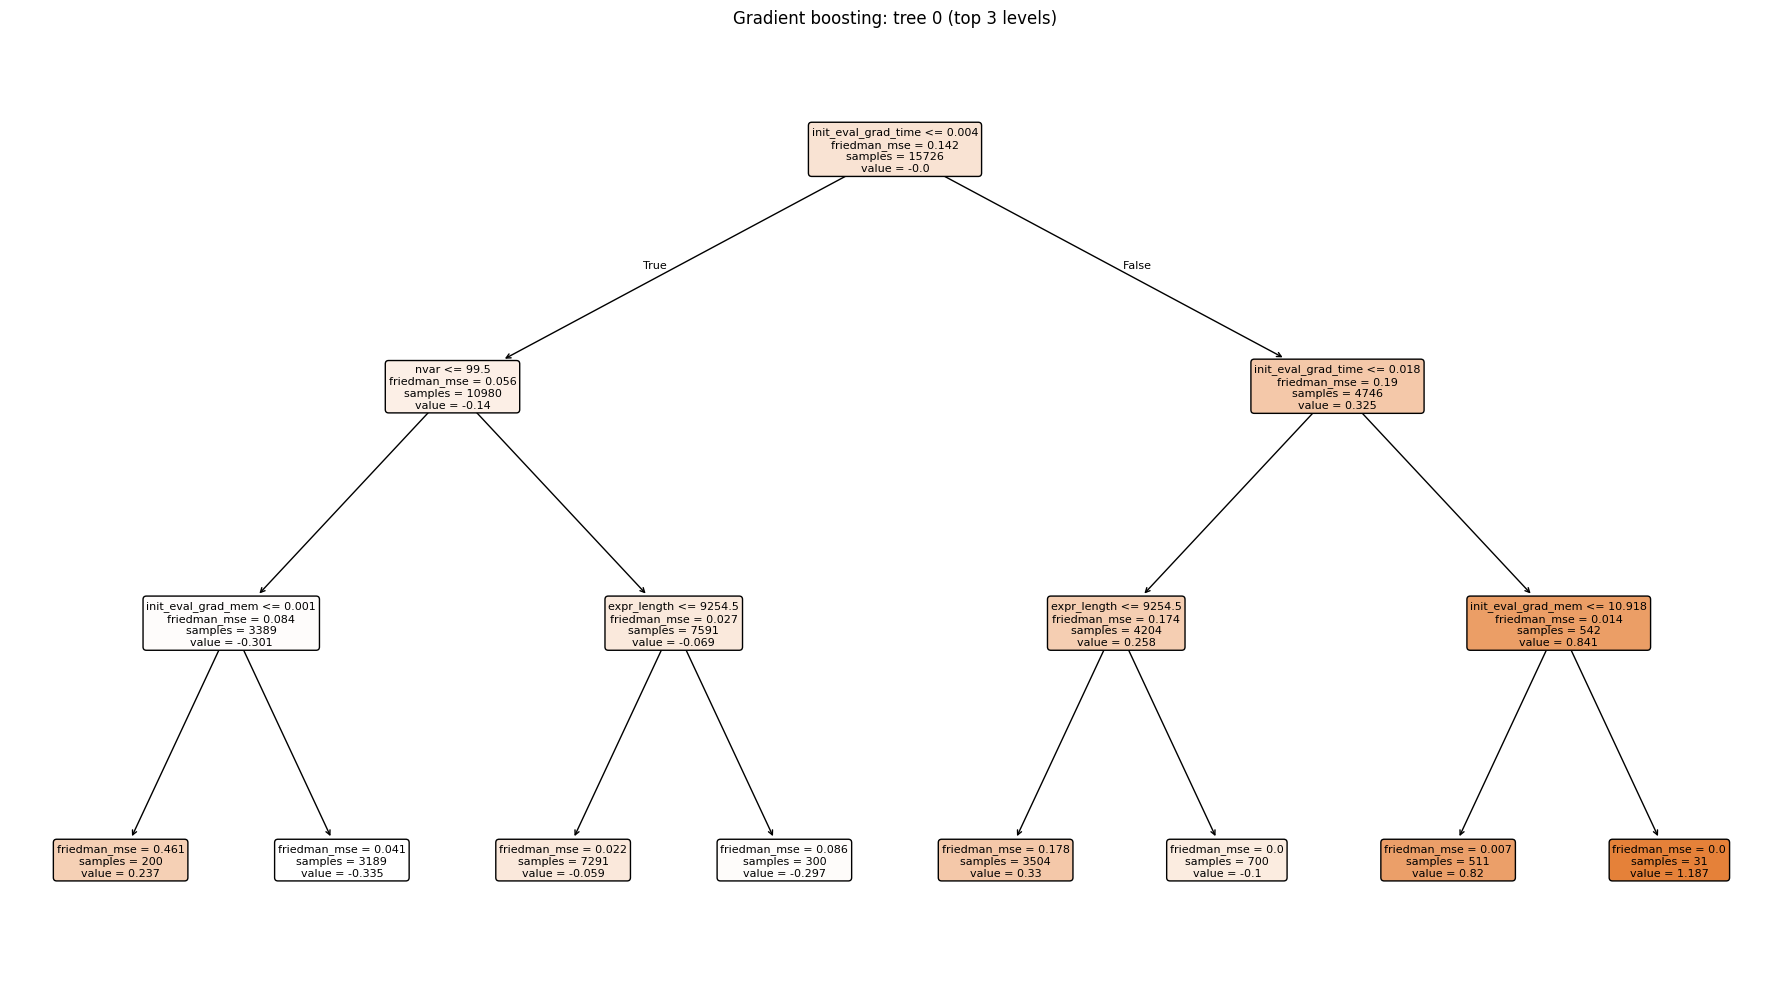

In [29]:
gb_tree0 = final_gb.estimators_[0, 0]

plt.figure(figsize=(18, 10))
tree.plot_tree(
    gb_tree0,
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8,
)
plt.title("Gradient boosting: tree 0 (top 3 levels)")
plt.tight_layout()
plt.show()


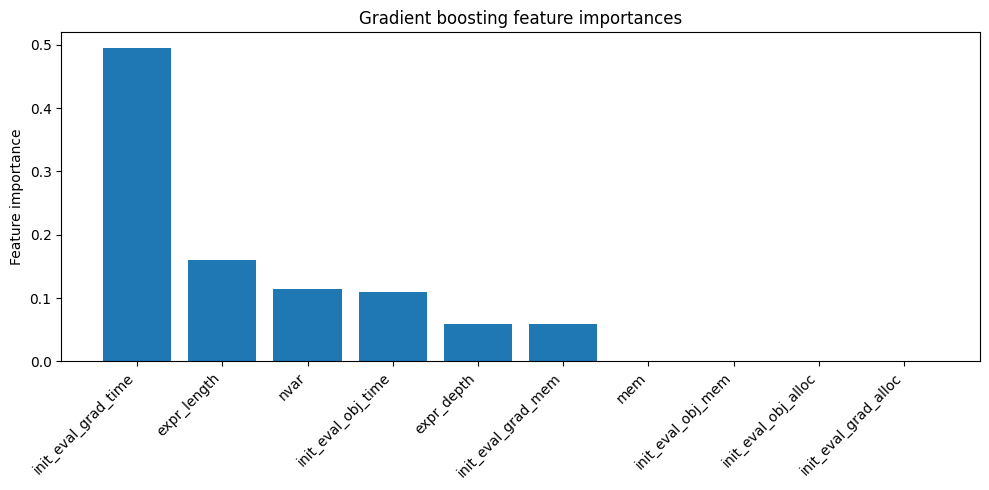

In [22]:
gb_importances = final_gb.feature_importances_
indices_gb = np.argsort(gb_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_cols)), gb_importances[indices_gb])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices_gb], rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Gradient boosting feature importances")
plt.tight_layout()
plt.show()
